/Users/louisarts/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/louisarts/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/louisarts/opt/anaconda3/lib/python3.9/site-packages/hmf/hmf.py:101: UserWarning: hmf is un-tested for redshifts greater than 2 and extreme masses. See https://github.com/steven-murray/HMFcalc/issues/6 for details.
  warnings.warn("hmf is un-tested for redshifts greater than 2 and extreme masses. See https://github.com/steven-murray/HMFcalc/issues/6 for details.")
/Users/louisarts/opt/anaconda3/lib/python3.9/site-packages/hmf/hmf.py:113: UserWarning: hmf is un-tested for redshifts greater t

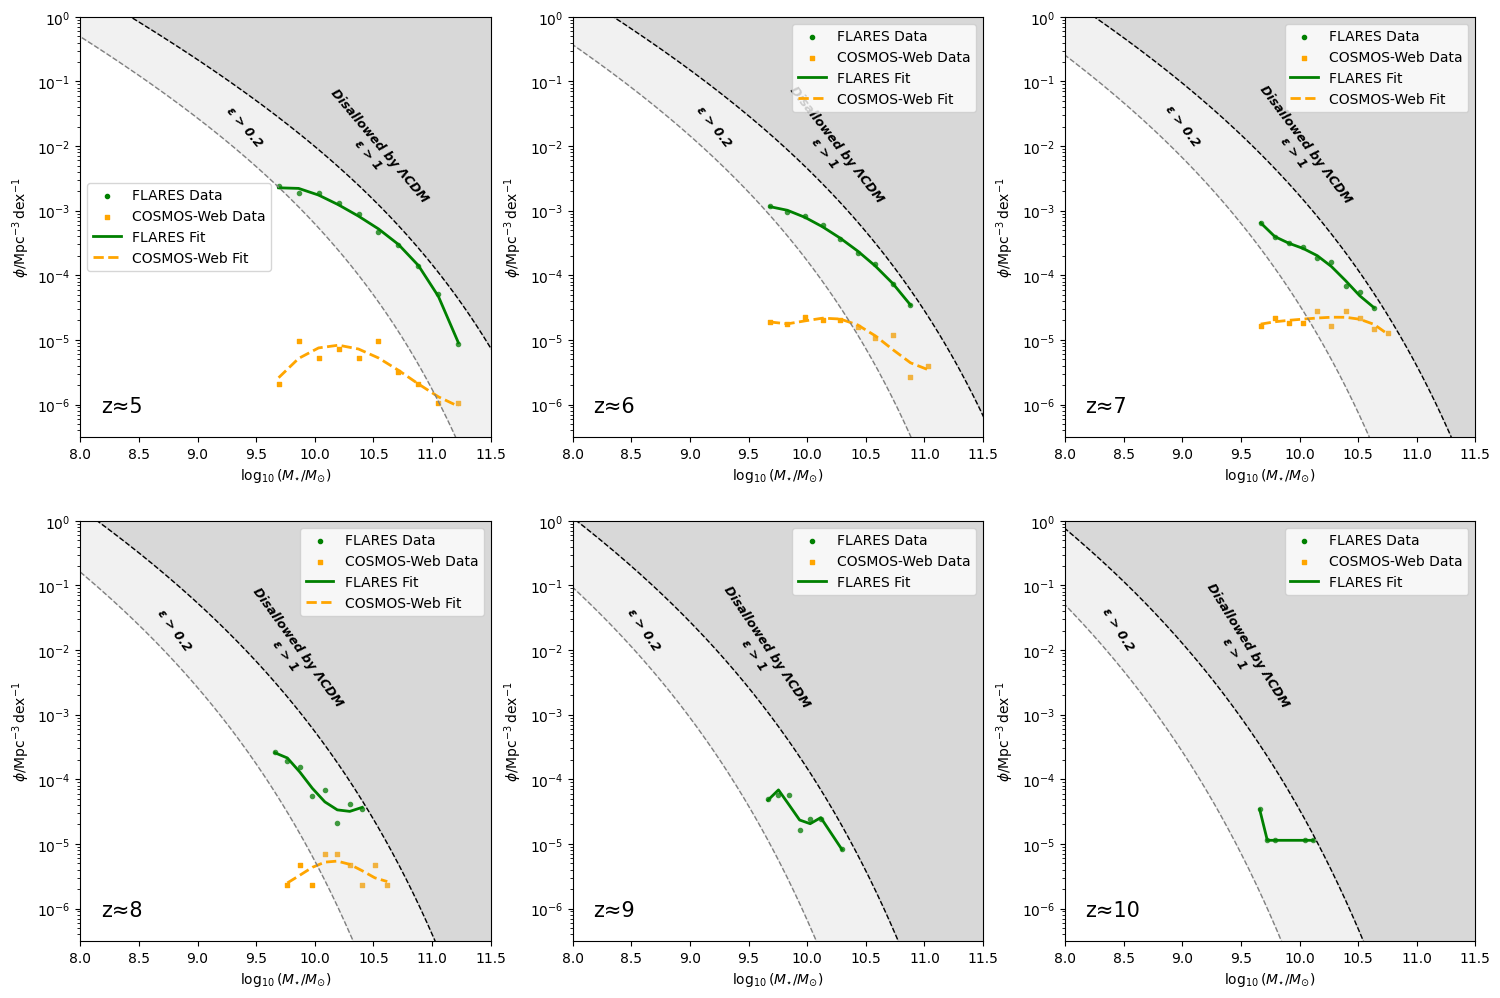

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from astropy.cosmology import Planck18 as cosmo
from hmf import MassFunction
import astropy.units as u

# Function to compute comoving distance for a given redshift
def comoving_distance(redshift):
    c = 299792.458  # Speed of light in km/s
    H0 = 67.4  # Hubble constant in km/s/Mpc
    Omega_m = 0.315  # Matter density parameter
    Omega_Lambda = 0.685  # Dark energy density parameter

    def H(z):
        return H0 * np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)

    def integrand(z):
        return c / H(z)

    distance, _ = quad(integrand, 0, redshift)
    return distance  # Returns distance in Mpc

# Function to compute comoving volume between two redshifts
def comoving_volume(redshift_close, redshift_far):
    solid_angle = 0.000165  # Solid angle in steradians
    comoving_dis_far = comoving_distance(redshift_far)
    comoving_dis_close = comoving_distance(redshift_close)
    comoving_vol_far = solid_angle * (1/3) * comoving_dis_far**3
    comoving_vol_close = solid_angle * (1/3) * comoving_dis_close**3
    return comoving_vol_far - comoving_vol_close

# Function to convert halo mass to stellar mass
def halomass_to_stellarmass(halo_mass, efficiency):
    baryon_fraction = 0.158  # Baryon fraction of the universe
    return halo_mass * baryon_fraction * efficiency

# Load the data
akins_data = pd.read_csv('../data/LRD_data.CSV')
flares_data = pd.read_csv('../data/filtered_FLARES_data.csv')
flares_data = flares_data[flares_data['Stellar Mass'] >= 0]  # Filter out non-physical values

# Define redshift bins
redshift_bins = [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5)]

# Function to calculate the number of galaxies in each mass bin
def calculate_bin_counts(data, n_bins, bin_edges, column_name):
    bin_counts = [0] * n_bins
    for mass in data[column_name]:
        for k in range(n_bins):
            if bin_edges[k] <= mass < bin_edges[k + 1]:
                bin_counts[k] += 1
                break
    return bin_counts

# Function to normalize counts to "number per dex"
def normalize_to_dex(bin_counts, bin_edges):
    bin_widths = np.diff(bin_edges)
    return bin_counts / bin_widths

# Function to fit a polynomial to the data and plot the fit
def plot_polynomial_fit(midpoints, counts, color, linestyle, label, ax):
    # Filter out zero counts
    midpoints_filtered = [mid for mid, count in zip(midpoints, counts) if count > 0]
    counts_filtered = [count for count in counts if count > 0]
    
    if midpoints_filtered and counts_filtered:
        p = np.polyfit(midpoints_filtered, np.log(counts_filtered), 4)
        fit = np.exp(np.polyval(p, midpoints_filtered))
        ax.plot(midpoints_filtered, fit, color=color, linestyle=linestyle, linewidth=2, label=label)

# Text positions for "Disallowed by ΛCDM\nε > 1"
disallowed_text_positions = [(10.5, 0.001), (10.2, 0.001), (10, 0.001), (9.8, 0.001), (9.6, 0.001), (9.5, 0.001)]

# Text positions for "ε > 0.2"
epsilon_text_positions = [(9.4, 0.01), (9.2, 0.01), (9, 0.01), (8.8, 0.01), (8.6, 0.01), (8.45, 0.01)]

# Rotation angles for each plot
rotation_angles = [-50, -52, -53, -54, -56, -58]

# Create the plots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

# Define common axis limits
x_lim = (8, 11.5)
y_lim = (10**(-6.5), 1)

# Loop over each redshift bin and create a subplot
for idx, (z_min, z_max) in enumerate(redshift_bins):
    redshift = (z_min + z_max) / 2
    
    # Compute halo mass function
    mf = MassFunction(Mmin=7, Mmax=15.5, hmf_model='Behroozi', z=redshift)
    halo_masses = mf.m
    stellar_masses_1 = halomass_to_stellarmass(halo_masses, 1)
    stellar_masses_0_2 = halomass_to_stellarmass(halo_masses, 0.2)
    log_stellar_masses_1 = np.log10(stellar_masses_1)
    log_stellar_masses_0_2 = np.log10(stellar_masses_0_2)
    dn_dlogM = mf.dndlog10m * cosmo.h**3  # Convert to correct units

    # Filter data for the current redshift bin
    akins_bin_data = akins_data[(akins_data['z_gal_med'] >= z_min) & (akins_data['z_gal_med'] <= z_max)]
    flares_bin_data = flares_data[(flares_data['Redshift'] >= z_min) & (flares_data['Redshift'] <= z_max)]
    
    # Define stellar mass bins and midpoints
    min_stellar_mass = min(flares_bin_data["Stellar Mass"])
    max_stellar_mass = max(flares_bin_data["Stellar Mass"])
    stellarmass_bins = np.linspace(min_stellar_mass, max_stellar_mass, 11)
    stellarmass_bin_midpoints = (stellarmass_bins[:-1] + stellarmass_bins[1:]) / 2
    
    # Calculate bin counts for both datasets
    bin_counts_flares = calculate_bin_counts(flares_bin_data, 10, stellarmass_bins, "Stellar Mass")
    bin_counts_akins = calculate_bin_counts(akins_bin_data, 10, stellarmass_bins, "logMstar_med")
    
    # Normalize to dex and volume
    norm_counts_flares = np.array(normalize_to_dex(bin_counts_flares, stellarmass_bins)) / 1352513  # FLARES volume in Mpc^3
    akins_volume = comoving_volume(z_min, z_max)
    norm_counts_akins = np.array(normalize_to_dex(bin_counts_akins, stellarmass_bins)) / akins_volume
    
    ax = axs[idx]
    
    # Plot data points
    ax.scatter(stellarmass_bin_midpoints, norm_counts_flares, color='green', marker='o', s=9, label='FLARES Data')
    ax.scatter(stellarmass_bin_midpoints, norm_counts_akins, color='orange', marker='s', s=9, label='COSMOS-Web Data')
    
    # Plot polynomial fits
    plot_polynomial_fit(stellarmass_bin_midpoints, norm_counts_flares, 'green', '-', 'FLARES Fit', ax)
    plot_polynomial_fit(stellarmass_bin_midpoints, norm_counts_akins, 'orange', '--', 'COSMOS-Web Fit', ax)
    
    # Plot halo mass function and shade disallowed regions
    ax.plot(log_stellar_masses_1, dn_dlogM, color='black', linestyle='--', linewidth=1)
    ax.fill_between(log_stellar_masses_1, dn_dlogM, y2=ax.get_ylim()[1], color='gray', alpha=0.3)
    ax.plot(log_stellar_masses_0_2, dn_dlogM, color='grey', linestyle='--', linewidth=1)
    ax.fill_betweenx(dn_dlogM, log_stellar_masses_0_2, log_stellar_masses_1, color='lightgrey', alpha=0.3)
    
    # Set axis limits and labels
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_yscale('log')
    ax.set_xlabel(r'$\log_{10} (M_{\star} / M_{\odot})$')
    ax.set_ylabel(r'$\phi / \mathrm{Mpc}^{-3} \, \mathrm{dex}^{-1}$')
    
    # Add annotations for disallowed regions
    disallowed_text_x, disallowed_text_y = disallowed_text_positions[idx]
    ax.text(disallowed_text_x, disallowed_text_y, "Disallowed by ΛCDM\nε > 1", fontsize=9, color='black', ha='center', fontstyle='italic', fontweight='bold', rotation=rotation_angles[idx])
    
    epsilon_text_x, epsilon_text_y = epsilon_text_positions[idx]
    ax.text(epsilon_text_x, epsilon_text_y, "ε > 0.2", fontsize=9, color='black', ha='center', fontstyle='italic', fontweight='bold', rotation=rotation_angles[idx])
    
    # Add redshift label
    ax.text(0.05, 0.05, f'z≈{int(z_max-0.5)}', transform=ax.transAxes, fontsize=15, color='black', ha='left', va='bottom')

    # Add legend
    ax.legend()


plt.show()
